## Purpose: Check whether the averaged IRF is valid or not.
#### Note that this project is based on the EventDisplay dataset.

In [2]:
%load_ext autoreload
%autoreload 2

from DarkMatter import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate a pseudo signal.
#### Assuming that $<\sigma\nu> = 10^{-22.5}$.

### 1-1. With averaged IRFs

In [92]:
M = 10000
dwarf="segue_1"
sigma = -23
package="EventDisplay"
jSeed = defaultNum[dwarf]
hg_1d = Likelihood.combinedCalcSignal(dwarf, M, "EventDisplay",
                                      decay="tt", jSeed=jSeed, 
                                      sigma=sigma, addTheta=False,
                                      averagedIRF=True, ext=True)

Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).


### 1-2. With individual IRFs

In [93]:
runlist = printRunList(dwarf, ext=True)

hg_array = np.zeros(len(getArray(hg_1d)[1]))

for run in tqdm(runlist):
    irf = ResponseFunction.EventDisplay.readIRFs(dwarf, run, ext=True)
    hg = Likelihood.calcSignal(dwarf, M, irf, package, jProfile = None, 
                               channel="tt", sigma=sigma, addTheta=False, 
                               jSeed = jSeed, ext=True)
    hg_array += getArray(hg)[1]
    
np.save("Test",hg_array )

  0%|          | 0/303 [00:00<?, ?it/s]

## 2. Compare the signal distribution

<ipython-input-95-ac421992e7f3>:12: RuntimeWarning: invalid value encountered in true_divide
  chi = np.sign(getArray(hg_1d)[1]-hg_array)*(getArray(hg_1d)[1]-hg_array)**2./hg_array


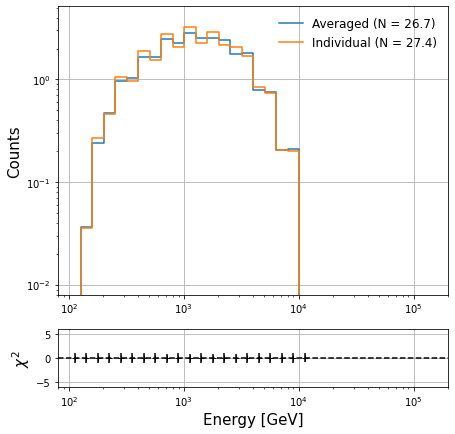

In [95]:

f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})
ax[0].step(*getArray(hg_1d), where="mid", label="Averaged (N = {:.1f})".format(sum(getArray(hg_1d)[1])))
ax[0].step(getArray(hg)[0], hg_array, where="mid", label="Individual (N = {:.1f})".format(sum(hg_array)))
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(80, 2e5)
ax[0].set_ylim(8e-3)
ax[0].set_ylabel("Counts", fontsize=15)
ax[0].legend(fontsize=12, loc=1, frameon=False)
ax[0].grid()

chi = np.sign(getArray(hg_1d)[1]-hg_array)*(getArray(hg_1d)[1]-hg_array)**2./hg_array
ax[1].errorbar(getArray(hg)[0], chi, yerr= 1, marker="+", ls="", c="k", label="chisq")
#ax[0].text(0.95, 0.6, r"$\chi^2$ / dof = {:.1f} / {} = {:.2f}".format(chisq, dof, chisq/dof), ha="right", fontsize=12, transform=ax[0].transAxes)
ax[1].set_ylabel(r"$\chi^2$", fontsize=15)
#ax[1].set_ylim(-max(abs(chi)+1.2), max(abs(chi)+1.2))

ax[1].set_xscale("log")
ax[1].set_xlabel("Energy [GeV]", fontsize=15)
ax[1].set_xlim(80, 2e5)
ax[1].set_ylim(-6, 6)
ax[1].axhline(0, color="k", ls="--")
ax[1].grid()

## 3. Perform the MLE analysis

### 3.1 With averaged IRFs

In [96]:
hg_1d = TH1D("hg_1D", "hg_1D", len(const.energyEdges)-1,const.energyEdges)
hg_1d.SetTitle("1D count spectrum")
hg_1d.GetXaxis().SetTitle("Energy [GeV]")
hg_1d.GetYaxis().SetTitle("Counts")

for i, cnt in enumerate(hg_array):
    hg_1d.SetBinContent(i, cnt)

plotRoot(hg_1d, logx=True)

mle = Likelihood.MLE(dwarf, M, package="EventDisplay", jArray=True, jSeed=jSeed,
                     addTheta=False, decay="tt", averagedIRF=True, bkgModel="ex", useBias=True,
                     verbose=True) 


mle.minuit()


[Log] Initializing... (EventDisplay)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=10000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-23.135) (equivalent to 7.34e-24)
[Log, Result] b = 13285 +/- 151 (null value: 13285)
[Log, Result] N_on = 2227, N_off = 2215, N_dm = 0


Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


### 3.2 With individual IRFs

In [97]:
mle = Likelihood.MLE(dwarf, M, package="EventDisplay", jArray=True, jSeed=jSeed,
                     addTheta=False, decay="tt", averagedIRF=True, bkgModel="ex", useBias=True,
                     verbose=True) 
mle.hSignal = hg_1d
mle.updateArgs()
mle.minuit()

[Log] Initializing... (EventDisplay)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=10000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-23.324) (equivalent to 4.74e-24)
[Log, Result] b = 13285 +/- 151 (null value: 13285)
[Log, Result] N_on = 2227, N_off = 2215, N_dm = 0
 MNCONT UNABLE TO FIND FOUR POINTS.


Warning in <TMinuit::Contour>: Cannot find more than 4 points, no TGraph returned


In [87]:
mle.updateArgs()
mle.minuit()

[Log, Result] TS = -0.00 (M=1000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-23.945) (equivalent to 1.14e-24)
[Log, Result] b = 13287 +/- 153 (null value: 13285)
[Log, Result] N_on = 2227, N_off = 2215, N_dm = 0
 MNCONT UNABLE TO FIND FOUR POINTS.


Warning in <TMinuit::Contour>: Cannot find more than 4 points, no TGraph returned
